In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


The gene state without feedback is determined by a two-state markov process with the following state-transition diagram:

$$
{\text{low} \atop (S=0)}
\quad
{{\alpha/\epsilon \atop\longrightarrow}\atop {\longleftarrow \atop  \beta/\epsilon}}
\quad
{\text{high} \atop (S=1)}\quad
$$

Where $S$ is the state of the gene, $\alpha$ is the rate of switching from low to high, and $\beta$ the rate from high to low.

With feedback inhibition, the state transition diagram of the gene state is as follows:

$$
{\text{low} \atop (S=0)}
\quad
{{\alpha/{N^2}{\epsilon}\atop\longrightarrow}\atop {\longleftarrow \atop  \beta/\epsilon}}
\quad
{\text{high} \atop (S=1)}\quad
$$

Where $N$ is the protein number in the system.


The protein number is determined stochastically with a birth-death process with a transition-state diagram as follows:

$$
(N-1)
{{{\gamma}{S(t)} \atop\longrightarrow}\atop {\longleftarrow \atop {\delta}{N}}}
(N)
{{\frac{{\gamma}{S(t)}+{\lambda}{(1-S(t))}}{\epsilon} \atop\longrightarrow}\atop {\longleftarrow \atop {\delta}{(N+1)}}}
(N+1)
$$

where $N$ is the protein number in the system, $S(t)$ is the gene state, $\delta$ the rate at which the protein leaves the system, $\gamma$ the low expression rate, and $\lambda$ the high expression rate.

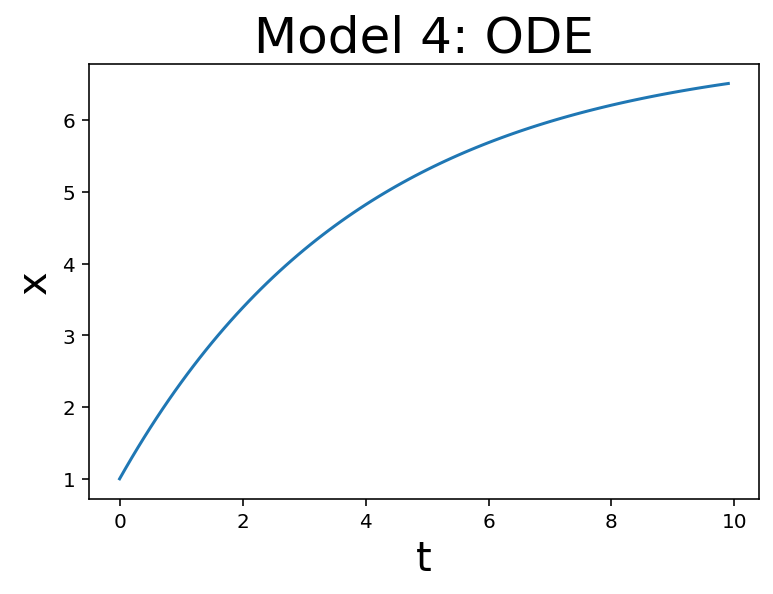

In [2]:
gamma = 2 #is it working?
lamda = 1
delta = 0.25 
alpha = 3.
beta = 1.
x0=1

Delta_t = 0.1
Nsteps = 100 
x = zeros(Nsteps) 
x[0] = x0 
def f_gene(x): 
    return gamma*alpha/(alpha+beta)+lamda*beta/(alpha+beta)-delta*x

for n in arange(1, Nsteps): 
    x[n] = x[n-1] + Delta_t*f_gene(x[n-1])

####### Plot the solution #########
t = Delta_t*arange(Nsteps) 
plot(t, x)
title("Model 4: ODE", fontsize = 25)
xlabel('t', fontsize=20)
ylabel('x', fontsize=20);

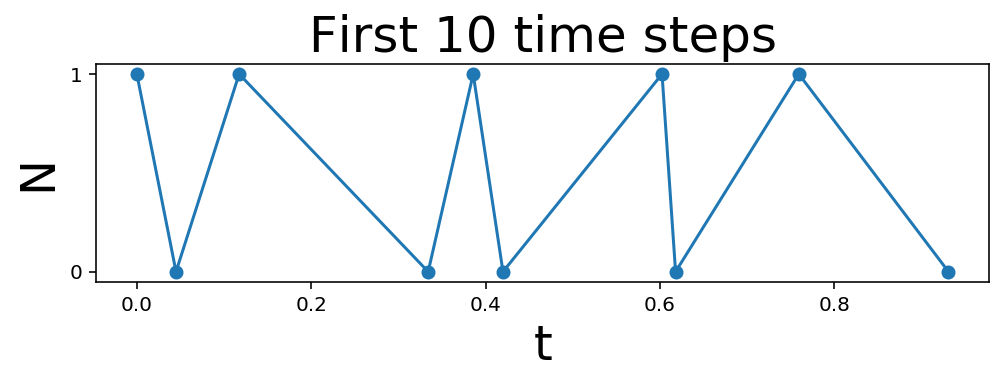

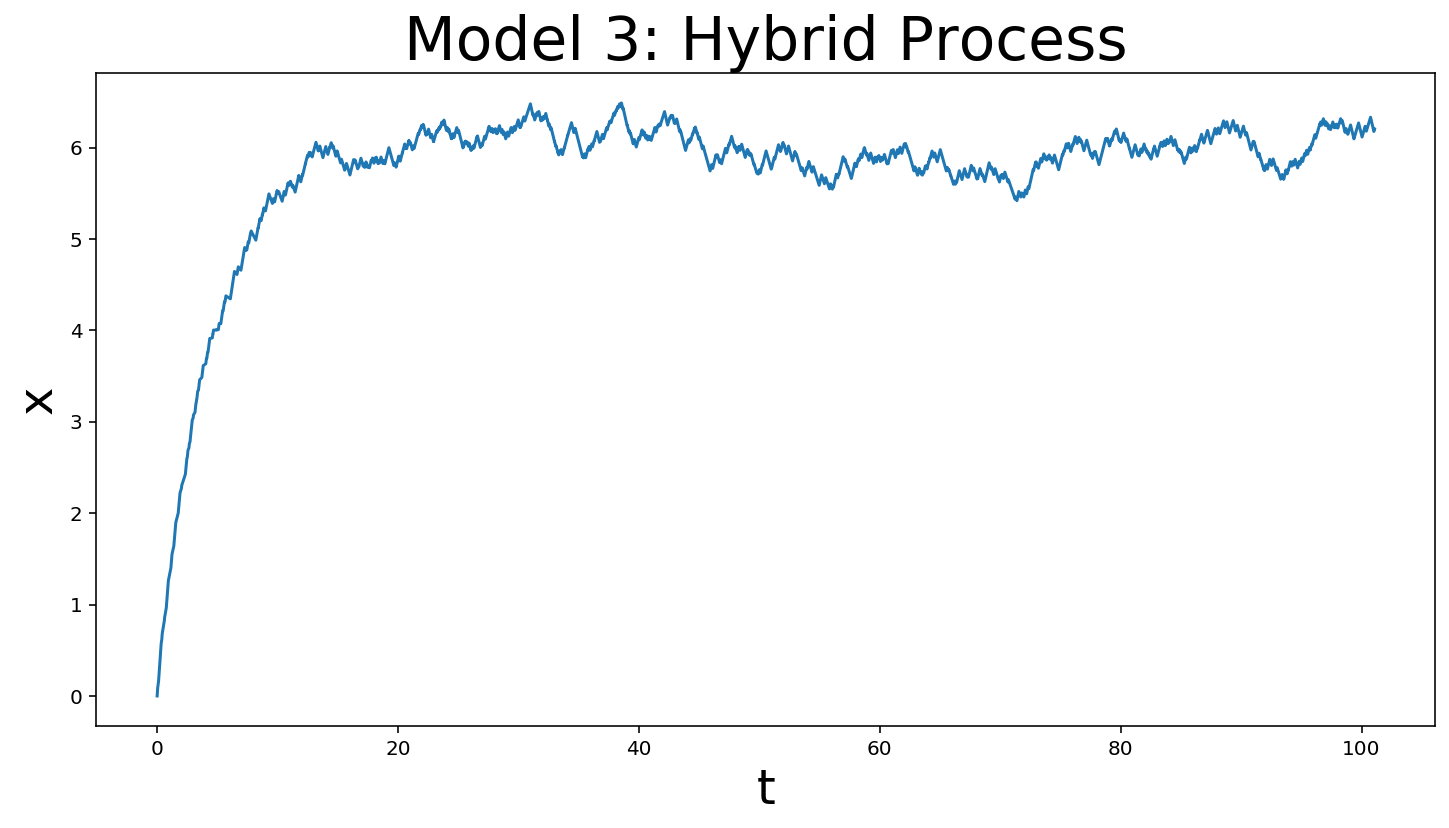

In [3]:
epsilon = 0.1
gamma = 2.
lamda = 1
delta = 0.25
alpha = 1.
beta = 1.
n0 = 0
s0 = 1
Nsteps = 1000
S = zeros(Nsteps)
S[0] = s0
N = zeros(Nsteps)
N[0] = n0
T = zeros(Nsteps)
T[0] = 0
def fullycoupledhybrid(alpha, beta, gamma, lamda, epsilon, s0, n0, Nsteps):
   
    S = zeros(Nsteps)
    S[0] = s0
    N = zeros(Nsteps)
    N[0] = n0
    T = zeros(Nsteps)
    T[0] = 0
    
    for j in arange(1, Nsteps):
        u = rand(1)[0]
        rate = beta/epsilon if S[j-1]==1 else alpha/(epsilon)
        tau = -log(u)/rate
        T[j] = T[j-1] + tau
        S[j] = 0 if S[j-1]==1 else 1
        ## update x using the exact solution above
        N[j] = N[j-1]*exp(-delta*tau) + (gamma*S[j-1]+lamda*(1-S[j-1]))/delta*(1 - exp(-delta*tau))
    return T, S, N

## I wan't to make a plot for the limiting ODE solution
Tinf = linspace(0, T[-1], 200)
Savg = alpha/(alpha + beta)
Xinf = x0*exp(-delta*Tinf) + gamma*Savg/delta*(1 - exp(-delta*Tinf))


T,S,N = fullycoupledhybrid(alpha, beta, gamma, lamda, epsilon, s0, n0, Nsteps)

figure(1, [8, 2])
plot(T[:10], S[:10], '-o')
yticks([0, 1])
title('First 10 time steps', fontsize=25)
xlabel('t', fontsize=24)
ylabel('N', fontsize=24);

figure(3, [12, 6])
plot(T, N)
title("Model 3: Hybrid Process", fontsize = 30)
xlabel('t', fontsize=24)
ylabel('x', fontsize=24);

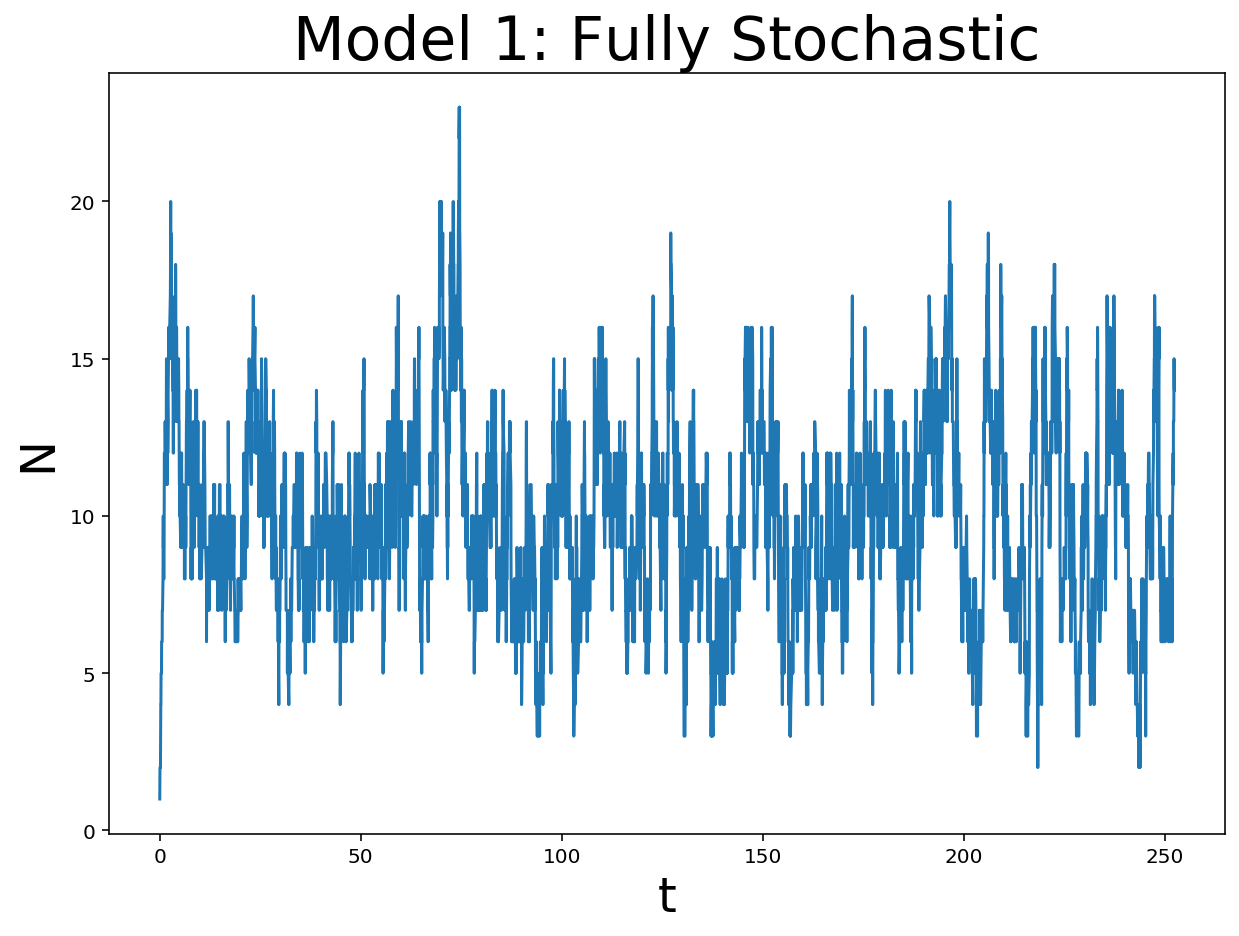

In [4]:
epsilon1 = 0.1#from birth death process
epsilon2 = 0.1#from state swithcing
gamma = 1
lamda = 1
delta = 1
alpha = 1
beta = 100
s0 = 0
n0 = 1
Nsteps = 10000
def stochastic_pp(alpha, beta, gamma, lamda, epsilon1,epsilon2, s0, n0, Nsteps):
    N = zeros(Nsteps)
    N[0] = n0
    S = zeros(Nsteps)
    S[0] = s0
    T = zeros(Nsteps)
    T[0] = 0
    for j in arange(1, Nsteps):
        s = S[j-1]
        n = N[j-1]
        if s == 0:
            rate = alpha/epsilon2
        if s == 1:
            rate = beta/epsilon2

        combined_rate = rate + (gamma*s + lamda*(1-s))/epsilon1 + (delta*(n))
        u = rand(1)
        tau = -log(u)/combined_rate
        T[j] = T[j-1] + tau
        probability_vector = array([rate, (gamma*s + lamda*(1-s))/epsilon1, (delta*(n))])/combined_rate
        cummulative_probability_vector = cumsum(probability_vector)
        u2 = rand(1)
        if u2 < cummulative_probability_vector[0]:
            if s == 0:
                S[j] = 1
            else:
                S[j] = 0
            N[j] = N[j-1]
        elif u2 < cummulative_probability_vector[1]:
            N[j] = N[j-1] + 1
            S[j] = S[j-1]
        else:
            N[j] = N[j-1] - 1
            S[j] = S[j-1]
    return T, S, N

figure(1, [10, 7])

###### Stochastic and ODE trajectories
T, S, N = stochastic_pp(alpha, beta, gamma, lamda, epsilon1,epsilon2, s0, n0, Nsteps)

plot(T, N)
title("Model 1: Fully Stochastic", fontsize = 30)
xlabel('t', fontsize=24)
ylabel('N', fontsize=24);

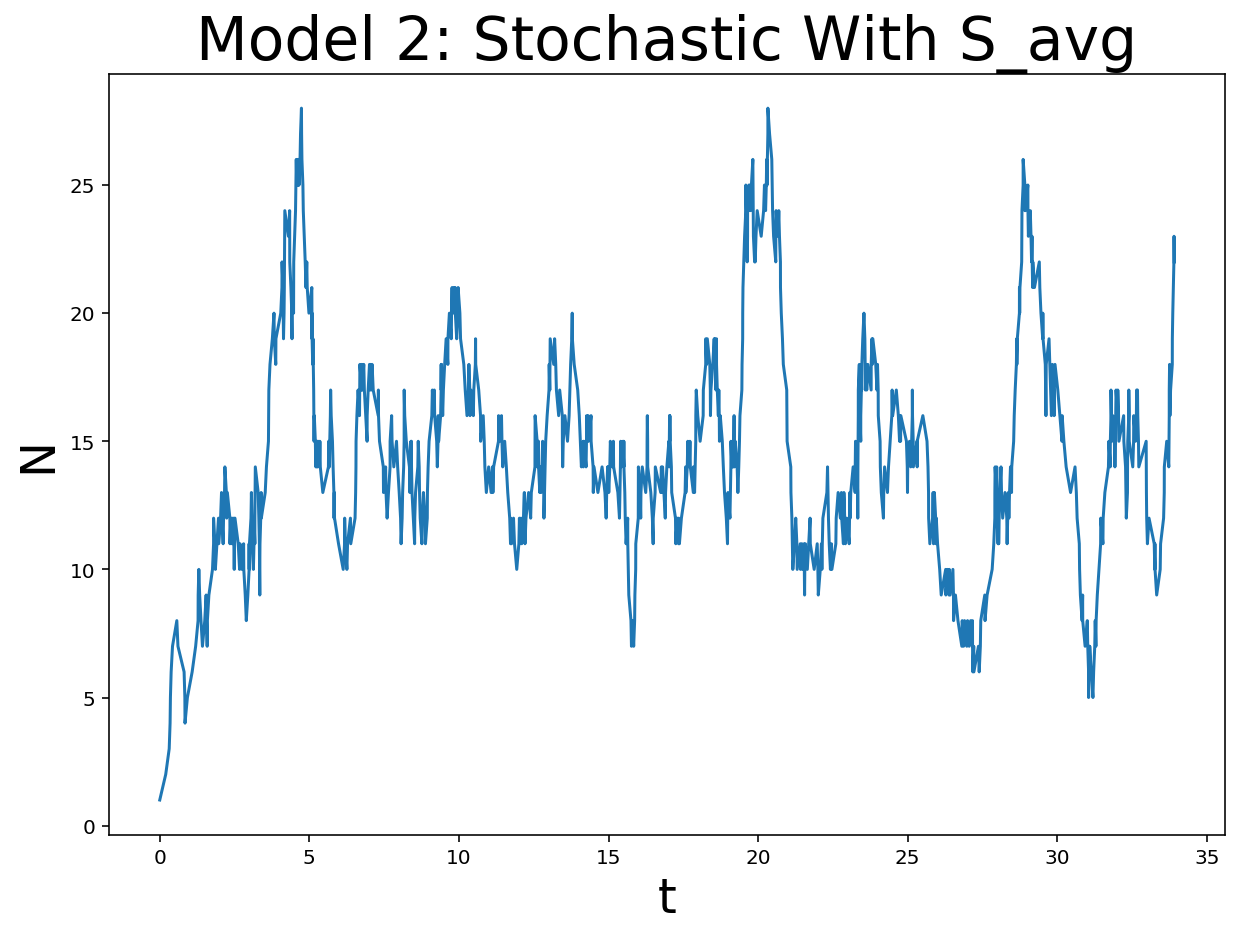

In [5]:
epsilon = 0.1
gamma = 2
lamda = 1
delta = 1
alpha = 1
beta = 1
s0 = 0
n0 = 1
Nsteps = 1000
def stochastic_pp_nomarkov(alpha, beta, gamma, lamda, epsilon, n0, Nsteps):
    N = zeros(Nsteps)
    N[0] = n0
    T = zeros(Nsteps)
    T[0] = 0
    s = alpha/(alpha+beta)
    for j in arange(1, Nsteps):
        n = N[j-1]
        combined_rate = (gamma*s + lamda*(1-s))/epsilon + (delta*n)
        u = rand(1)
        tau = -log(u)/combined_rate
        T[j] = T[j-1] + tau
        probability_vector = array([(gamma*s + lamda*(1-s))/epsilon, (delta*(n))])/combined_rate
        cummulative_probability_vector = cumsum(probability_vector)
        u2 = rand(1)
        if u2 < cummulative_probability_vector[0]:
            N[j] = N[j-1] + 1
        else:
            N[j] = N[j-1] - 1
            
    return T, N

figure(1, [10, 7])

###### Stochastic and ODE trajectories
T,N = stochastic_pp_nomarkov(alpha, beta, gamma, lamda, epsilon, n0, Nsteps)

plot(T, N)
title("Model 2: Stochastic With S_avg", fontsize = 30)
xlabel('t', fontsize=24)
ylabel('N', fontsize=24);

(0, 50)

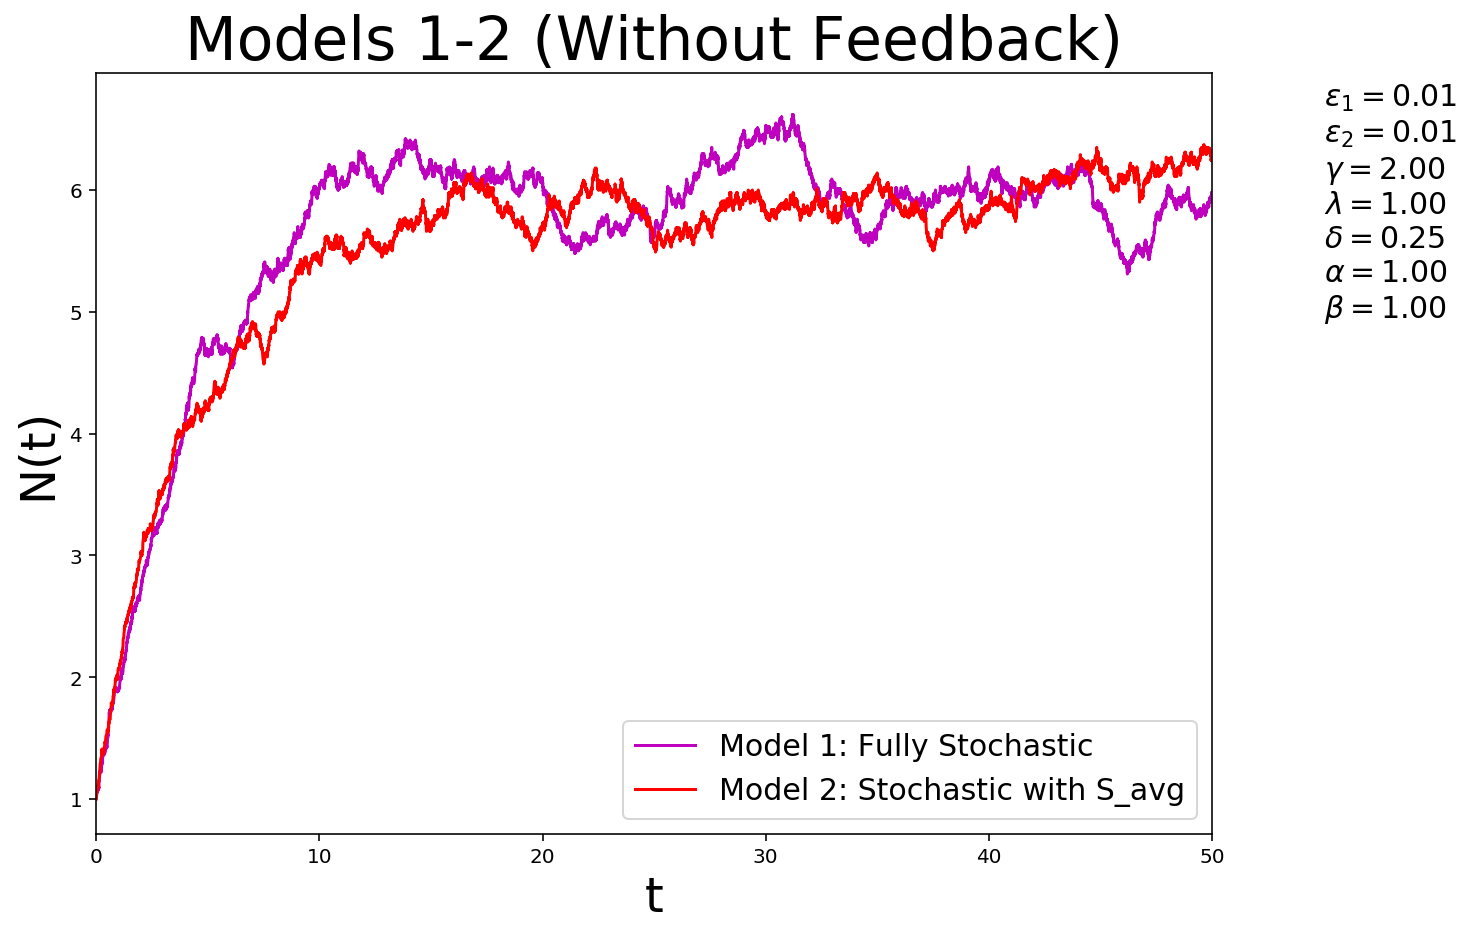

In [38]:
epsilon = 0.01
epsilon1 = 0.01#from birth death process
epsilon2 = 0.01
gamma = 2.
lamda = 1
delta = 0.25
alpha = 1.
beta = 1.
n0 = 1
s0 = 1
Delta_t = 0.1
Nsteps = 10000

T1, S1, N1 = stochastic_pp(alpha, beta, gamma, lamda, epsilon1,epsilon2, s0, 1/epsilon, Nsteps*5)

T2,N2 = stochastic_pp_nomarkov(alpha, beta, gamma, lamda, epsilon, 1/epsilon, Nsteps*5)

figure(1, [10, 7]) 
title('Models 1-2 (Without Feedback)', fontsize = 30)
xlabel('t', fontsize = 24)
ylabel('N(t)', fontsize = 24)
plot(T1,(epsilon)*N1, 'm', label = "Model 1: Fully Stochastic")
plot(T2,epsilon*N2, 'r',label = "Model 2: Stochastic with S_avg")
legend(loc = 'lower right', fontsize = 15)
textstr = '\n'.join((
    r'$\epsilon_1=%.2f$' % (epsilon1, ),
    r'$\epsilon_2=%.2f$' % (epsilon2, ),
    r'$\gamma=%.2f$' % (gamma, ),
    r'$\lambda=%.2f$' % (lamda, ),
    r'$\delta=%.2f$' % (delta, ),
    r'$\alpha=%.2f$' % (alpha, ),
    r'$\beta=%.2f$' % (beta, )))
text(55,5,textstr ,fontsize = 15, wrap = True)
xlim([0,50])

(0, 50)

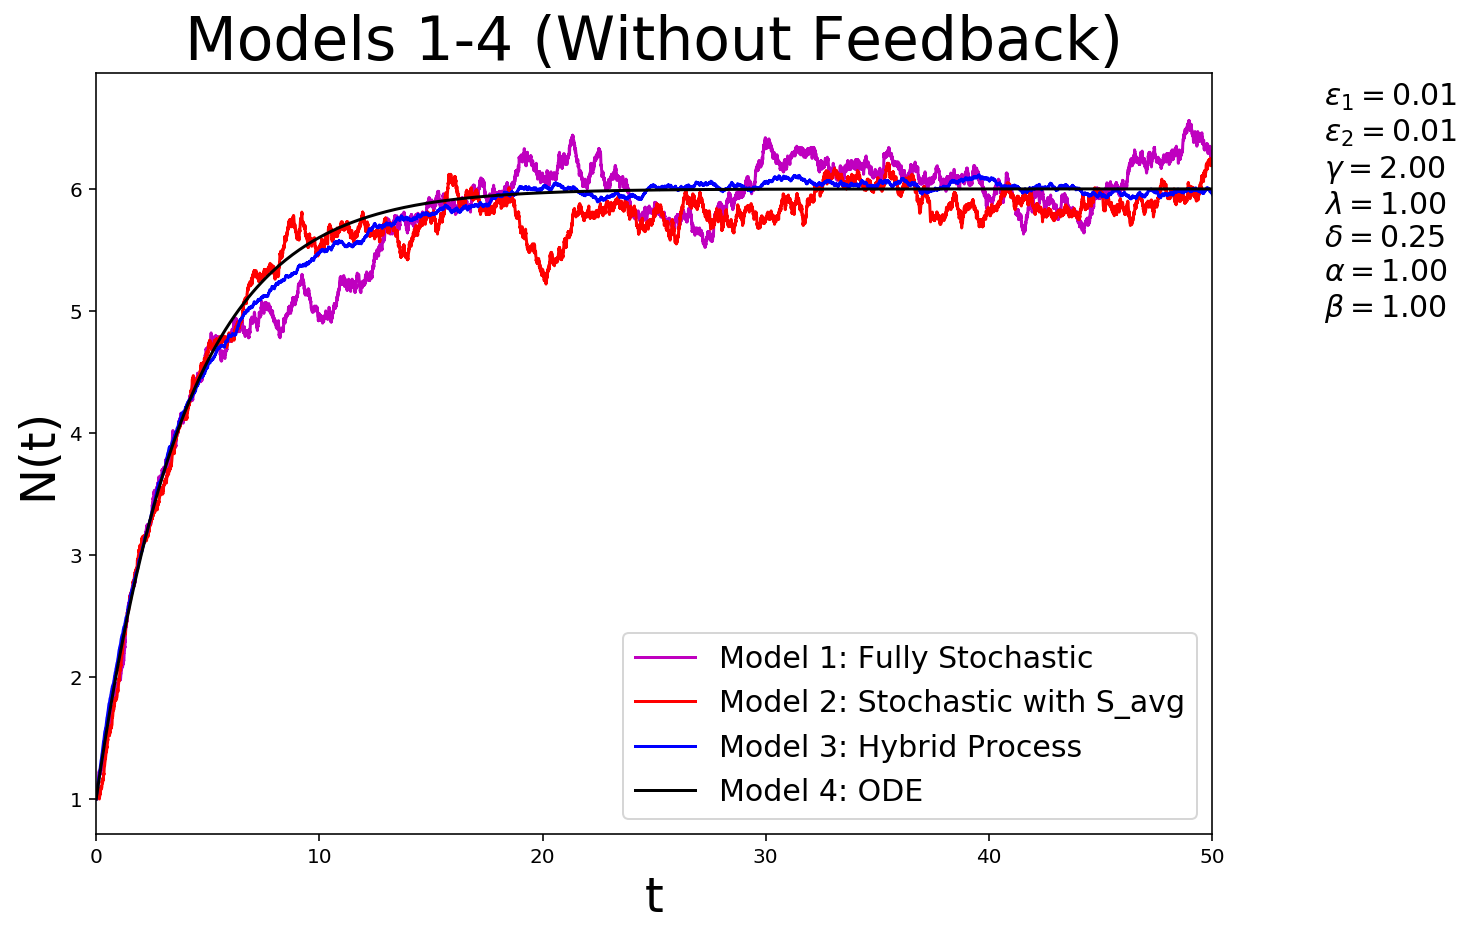

In [29]:
epsilon = 0.01
epsilon1 = 0.01#from birth death process
epsilon2 = 0.01#from state switching
gamma =2
lamda = 1
delta = 0.25
alpha = 1.
beta = 1.
n0 = 1
s0 = 1
Delta_t = 0.1
Nsteps = 10000
x = zeros(Nsteps) 
x[0] = 1



T1, S1, N1 = stochastic_pp(alpha, beta, gamma, lamda, epsilon1,epsilon2, s0, 1/epsilon, Nsteps*5)

T2,N2 = stochastic_pp_nomarkov(alpha, beta, gamma, lamda, epsilon, 1/epsilon, Nsteps*5)

T3,S3,N3 = fullycoupledhybrid(alpha, beta, gamma, lamda, epsilon, s0, n0, Nsteps)

for n in arange(1, Nsteps): 
    x[n] = x[n-1] + Delta_t*f_gene(x[n-1])
T4 = Delta_t*arange(Nsteps) 
figure(1, [10, 7]) 
title('Models 1-4 (Without Feedback)', fontsize = 30)
xlabel('t', fontsize = 24)
ylabel('N(t)', fontsize = 24)
plot(T1,(epsilon)*N1, 'm', label = "Model 1: Fully Stochastic")
plot(T2,epsilon*N2, 'r',label = "Model 2: Stochastic with S_avg")
plot(T3,N3,'b',label = "Model 3: Hybrid Process")
plot(T4,x, 'k',label = "Model 4: ODE",);
legend(fontsize = 15)
textstr = '\n'.join((
    r'$\epsilon_1=%.2f$' % (epsilon1, ),
    r'$\epsilon_2=%.2f$' % (epsilon2, ),
    r'$\gamma=%.2f$' % (gamma, ),
    r'$\lambda=%.2f$' % (lamda, ),
    r'$\delta=%.2f$' % (delta, ),
    r'$\alpha=%.2f$' % (alpha, ),
    r'$\beta=%.2f$' % (beta, )))
text(55,5,textstr ,fontsize = 15, wrap = True)
xlim([0,50])